In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)+1 #Plus EOS marker

def findFiles(path): 
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) !=
    'Mn' and c in all_letters)

def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [4]:
category_lines = {}
all_categoties = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categoties.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categoties)
if n_categories ==0:
    raise RuntimeError('Data not found.Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
print('# categories: ',n_categories,all_categoties)
print(unicodeToAscii("O'Néàl"))

# categories:  18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


Creating  RNN

In [5]:
import torch
import torch.nn as nn

In [6]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories+input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories+input_size+hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size+output_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,category,input,hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

Training

Prepare for Training

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categoties)
    line = randomChoice(category_lines[category])
    return category,line

In [8]:
def categoryTensor(category):
    li = all_categoties.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor
def inputTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in 
                     range(1,len(line))]
    letter_indexes.append(n_letters-1) # EOS
    return torch.LongTensor(letter_indexes)
    

In [9]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    targwt_line_tensor = targetTensor(line)
    return category_tensor,input_line_tensor,targwt_line_tensor

In [16]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds'%(m,s)

In [17]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 2.9334
0m 37s (10000 10%) 2.7839
0m 55s (15000 15%) 2.2272
1m 13s (20000 20%) 3.0141
1m 32s (25000 25%) 2.0393
1m 49s (30000 30%) 2.7194
2m 7s (35000 35%) 3.6483
2m 25s (40000 40%) 3.4703
2m 43s (45000 45%) 2.3166
3m 2s (50000 50%) 3.1557
3m 21s (55000 55%) 1.8766
3m 39s (60000 60%) 2.3034
3m 57s (65000 65%) 1.2183
4m 15s (70000 70%) 2.8347
4m 33s (75000 75%) 2.0313
4m 52s (80000 80%) 2.7714
5m 10s (85000 85%) 1.7720
5m 30s (90000 90%) 1.7864
5m 49s (95000 95%) 1.0279
6m 7s (100000 100%) 2.6952


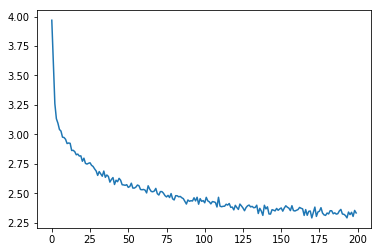

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [21]:
max_length = 20
def sample(category,start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor,input[0],hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name
    
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))
        
samples('Russian','RUS')
samples('German','GER')
samples('Spanish','SPA')


Roverovev
Uakinov
Sakinov
Ganger
Erenger
Roure
Salla
Pare
Ander
